# 数据加载

In [1]:
%load_ext autoreload
%autoreload 2

try:
# 运行环境在colab需要加载的代码
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ConvNetFromScratch'
    GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
    print(os.listdir(GOOGLE_DRIVE_PATH))
    import sys
    sys.path.append(GOOGLE_DRIVE_PATH)
except:
    pass

import time, os, torch, torchvision, random, time, math
from torch import Tensor
import torchvision
import matplotlib.pyplot as plt
from toolset import *
from toolset.utils import *
from toolset.data import *
from toolset.helper import *
from toolset.solver import *
from convolutional_networks import *
from fully_connected_networks import *


%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 10

if torch.cuda.is_available:
    print('Good to go!')

Good to go!


In [2]:
data_dict = data.preprocess_cifar10(cuda=True, dtype=torch.float32, flatten=False,show_examples=False)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)
input_dims = data_dict['X_train'].shape[1:]

Train data shape:  torch.Size([40000, 3, 32, 32])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3, 32, 32])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3, 32, 32])
Test labels shape:  torch.Size([10000])


# 搜索参数

In [3]:
# 确定网络结构，搜索一个较好的学习率和正则化比率以让模型快速过拟合测试样本
def search_params():
    # 第一次搜索
    learing_rate = [1e-3, 5e-4, 1e-4,5e-5]
    regs = [5e-4, 1e-5]
    
    # 第二次搜索
    # learing_rate = [5e-4, 1e-4, 5e-5]
    # regs = [5e-4]
    small_data = {
        'X_train': data_dict['X_train'][:300],
        'y_train': data_dict['y_train'][:300],
        'X_val': data_dict['X_val'][:1],
        'y_val': data_dict['y_val'][:1],
    }
    for reg in regs:
        for lr in learing_rate:
            
            net = VggNet(
                        input_dims=(3, 32, 32),
                        num_filters=(128, 256, 
                                     512, 512),
                        num_FC=(256, 256, 10),
                        max_pools=(1,),
                        weight_scale='kaiming',
                        kaiming_ratio=0.8,
                        reg=reg,
                        dtype=torch.float32,
                        # print_params=False,
                        # dropout=0.6,
                        device='cuda'
            )
            # net16.check_loss(data_dict=data_dict)  # 检查初始loss值，不宜过大
            solver = Solver(net, small_data,
                            num_epochs=18, batch_size=50,
                            optim_config={
                                'learning_rate': lr,
                            },
                            update_rule=adam,
                            verbose=True,
                            device='cuda',
                            lr_decay=0.95,
                            print_every=50,
                            check_batch_size=200
                            )
            print(f"lr:{lr}  reg:{reg}")
            solver.train(time_limit=4200)
            plot_solver(solver)
            solver._reset()
            clear(solver)
            clear(net)

lr:0.001  reg:0.0005
(用时 0.76s; 迭代次数1 / 108) loss: 3.254214
(Epoch 0 / 18, train 准确率: 12.33%, val准确率: 0.00%
(Epoch 1 / 18, train 准确率: 21.33%, val准确率: 100.00%
更新:当前准确率100.00, 大于之前的最佳准确率0.00

(Epoch 2 / 18, train 准确率: 21.33%, val准确率: 100.00%
(Epoch 3 / 18, train 准确率: 20.67%, val准确率: 100.00%
(Epoch 4 / 18, train 准确率: 30.67%, val准确率: 100.00%
(Epoch 5 / 18, train 准确率: 65.33%, val准确率: 100.00%
(Epoch 6 / 18, train 准确率: 73.00%, val准确率: 0.00%
(Epoch 7 / 18, train 准确率: 65.00%, val准确率: 100.00%
(Epoch 8 / 18, train 准确率: 43.00%, val准确率: 0.00%
(用时 12.90s; 迭代次数51 / 108) loss: 1.606354
(Epoch 9 / 18, train 准确率: 79.67%, val准确率: 0.00%
(Epoch 10 / 18, train 准确率: 46.00%, val准确率: 0.00%
(Epoch 11 / 18, train 准确率: 76.00%, val准确率: 0.00%
(Epoch 12 / 18, train 准确率: 52.00%, val准确率: 0.00%
(Epoch 13 / 18, train 准确率: 94.33%, val准确率: 100.00%
(Epoch 14 / 18, train 准确率: 99.33%, val准确率: 100.00%
(Epoch 15 / 18, train 准确率: 93.00%, val准确率: 0.00%
(Epoch 16 / 18, train 准确率: 99.33%, val准确率: 100.00%
(用时 24.17s; 迭代次数101 / 108)

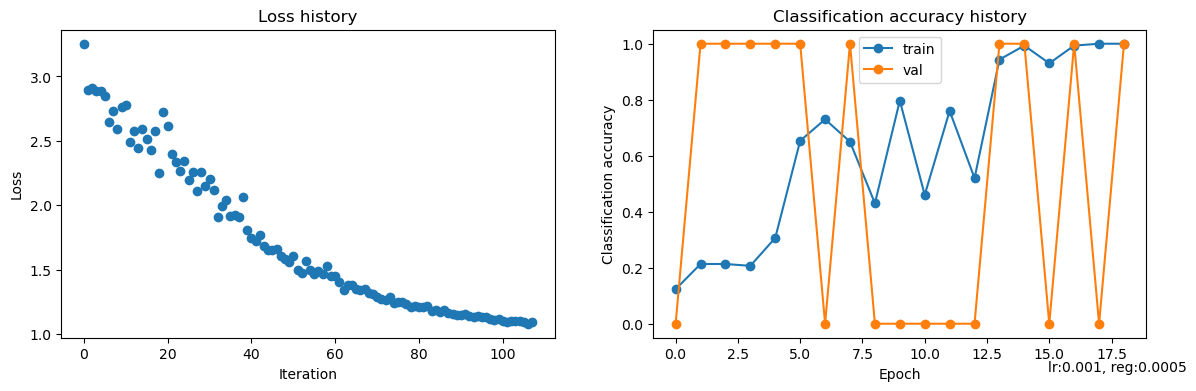

lr:0.0005  reg:0.0005
(用时 0.17s; 迭代次数1 / 108) loss: 3.447248
(Epoch 0 / 18, train 准确率: 12.00%, val准确率: 0.00%
(Epoch 1 / 18, train 准确率: 16.00%, val准确率: 100.00%
更新:当前准确率100.00, 大于之前的最佳准确率0.00

(Epoch 2 / 18, train 准确率: 32.00%, val准确率: 100.00%
(Epoch 3 / 18, train 准确率: 14.67%, val准确率: 100.00%
(Epoch 4 / 18, train 准确率: 48.67%, val准确率: 100.00%
(Epoch 5 / 18, train 准确率: 62.00%, val准确率: 100.00%
(Epoch 6 / 18, train 准确率: 56.67%, val准确率: 0.00%
(Epoch 7 / 18, train 准确率: 95.33%, val准确率: 100.00%
(Epoch 8 / 18, train 准确率: 75.67%, val准确率: 100.00%
(用时 12.40s; 迭代次数51 / 108) loss: 1.100094
(Epoch 9 / 18, train 准确率: 41.33%, val准确率: 0.00%
(Epoch 10 / 18, train 准确率: 99.00%, val准确率: 0.00%
(Epoch 11 / 18, train 准确率: 99.67%, val准确率: 100.00%
(Epoch 12 / 18, train 准确率: 99.67%, val准确率: 0.00%
(Epoch 13 / 18, train 准确率: 100.00%, val准确率: 0.00%
(Epoch 14 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 15 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 16 / 18, train 准确率: 100.00%, val准确率: 100.00%
(用时 23.73s; 迭代次数1

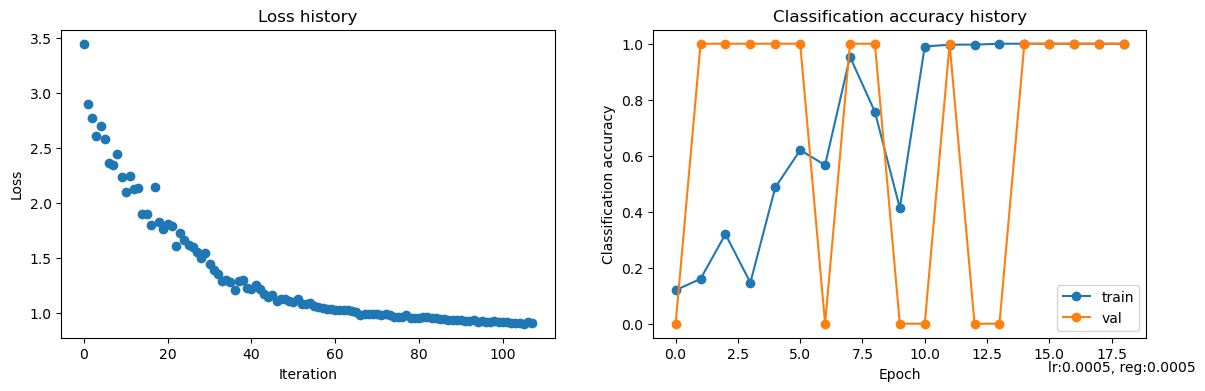

lr:0.0001  reg:0.0005
(用时 0.17s; 迭代次数1 / 108) loss: 3.311486
(Epoch 0 / 18, train 准确率: 14.00%, val准确率: 0.00%
(Epoch 1 / 18, train 准确率: 21.00%, val准确率: 0.00%
(Epoch 2 / 18, train 准确率: 34.33%, val准确率: 0.00%
(Epoch 3 / 18, train 准确率: 78.00%, val准确率: 100.00%
更新:当前准确率100.00, 大于之前的最佳准确率0.00

(Epoch 4 / 18, train 准确率: 93.33%, val准确率: 100.00%
(Epoch 5 / 18, train 准确率: 95.00%, val准确率: 100.00%
(Epoch 6 / 18, train 准确率: 99.33%, val准确率: 100.00%
(Epoch 7 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 8 / 18, train 准确率: 99.67%, val准确率: 100.00%
(用时 12.42s; 迭代次数51 / 108) loss: 1.070817
(Epoch 9 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 10 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 11 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 12 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 13 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 14 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 15 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 16 / 18, train 准确率: 100.00%, val准确率: 100.00%
(用时 23

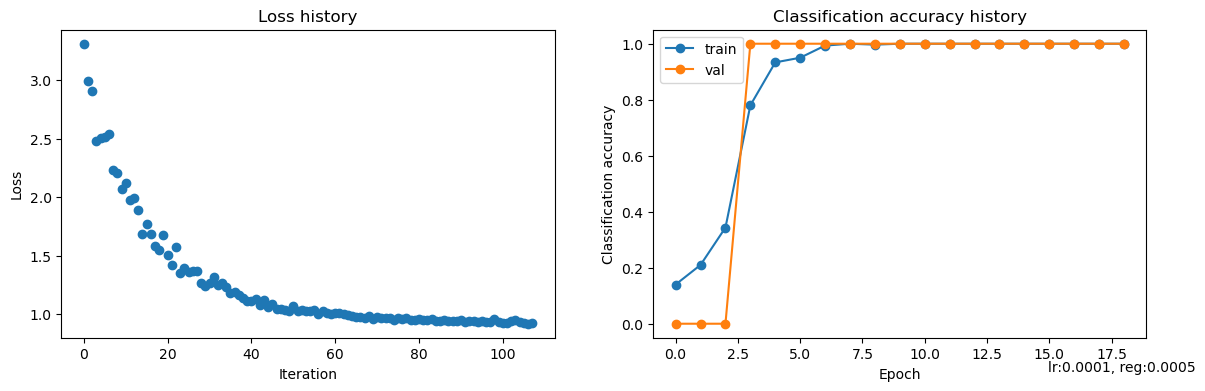

lr:5e-05  reg:0.0005
(用时 0.17s; 迭代次数1 / 108) loss: 3.153045
(Epoch 0 / 18, train 准确率: 19.00%, val准确率: 0.00%
(Epoch 1 / 18, train 准确率: 34.33%, val准确率: 0.00%
(Epoch 2 / 18, train 准确率: 48.67%, val准确率: 0.00%
(Epoch 3 / 18, train 准确率: 66.00%, val准确率: 100.00%
更新:当前准确率100.00, 大于之前的最佳准确率0.00

(Epoch 4 / 18, train 准确率: 92.33%, val准确率: 100.00%
(Epoch 5 / 18, train 准确率: 98.33%, val准确率: 100.00%
(Epoch 6 / 18, train 准确率: 99.33%, val准确率: 100.00%
(Epoch 7 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 8 / 18, train 准确率: 100.00%, val准确率: 100.00%
(用时 12.43s; 迭代次数51 / 108) loss: 1.084392
(Epoch 9 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 10 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 11 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 12 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 13 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 14 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 15 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 16 / 18, train 准确率: 100.00%, val准确率: 100.00%
(用时 23

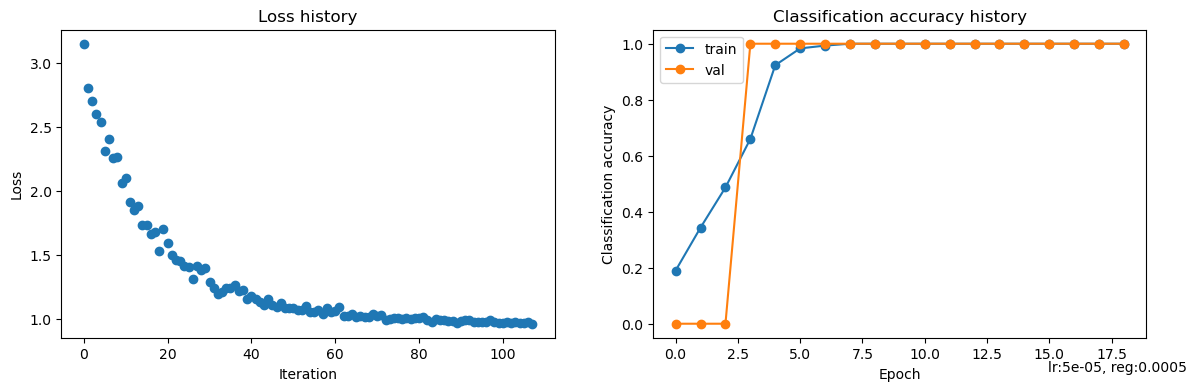

lr:0.001  reg:1e-05
(用时 0.17s; 迭代次数1 / 108) loss: 2.539313
(Epoch 0 / 18, train 准确率: 14.00%, val准确率: 100.00%
更新:当前准确率100.00, 大于之前的最佳准确率0.00

(Epoch 1 / 18, train 准确率: 26.67%, val准确率: 0.00%
(Epoch 2 / 18, train 准确率: 15.67%, val准确率: 0.00%
(Epoch 3 / 18, train 准确率: 25.00%, val准确率: 100.00%
(Epoch 4 / 18, train 准确率: 26.00%, val准确率: 100.00%
(Epoch 5 / 18, train 准确率: 35.00%, val准确率: 100.00%
(Epoch 6 / 18, train 准确率: 39.67%, val准确率: 0.00%
(Epoch 7 / 18, train 准确率: 61.33%, val准确率: 100.00%
(Epoch 8 / 18, train 准确率: 68.33%, val准确率: 0.00%
(用时 12.39s; 迭代次数51 / 108) loss: 0.294589
(Epoch 9 / 18, train 准确率: 89.67%, val准确率: 100.00%
(Epoch 10 / 18, train 准确率: 76.00%, val准确率: 0.00%
(Epoch 11 / 18, train 准确率: 71.33%, val准确率: 0.00%
(Epoch 12 / 18, train 准确率: 84.67%, val准确率: 100.00%
(Epoch 13 / 18, train 准确率: 98.33%, val准确率: 100.00%
(Epoch 14 / 18, train 准确率: 99.67%, val准确率: 0.00%
(Epoch 15 / 18, train 准确率: 99.00%, val准确率: 0.00%
(Epoch 16 / 18, train 准确率: 100.00%, val准确率: 0.00%
(用时 23.72s; 迭代次数101 / 108) l

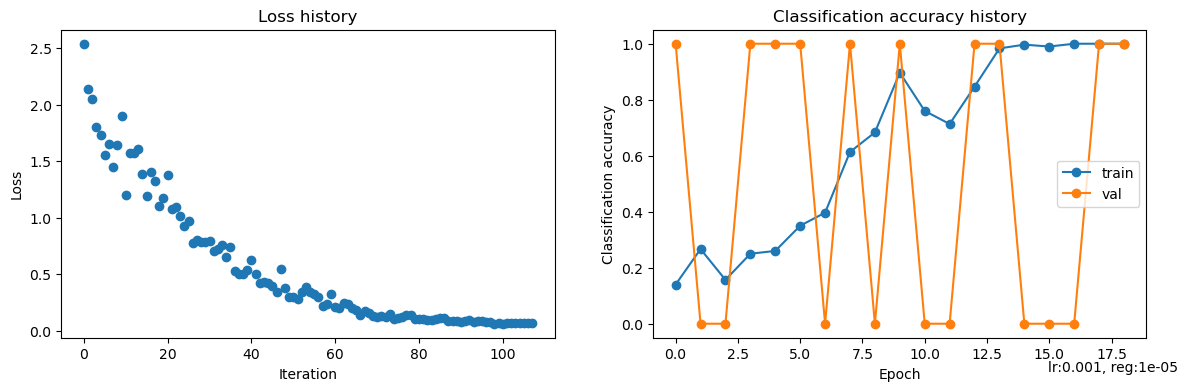

lr:0.0005  reg:1e-05
(用时 0.17s; 迭代次数1 / 108) loss: 2.448779
(Epoch 0 / 18, train 准确率: 20.33%, val准确率: 100.00%
更新:当前准确率100.00, 大于之前的最佳准确率0.00

(Epoch 1 / 18, train 准确率: 21.67%, val准确率: 100.00%
(Epoch 2 / 18, train 准确率: 20.00%, val准确率: 100.00%
(Epoch 3 / 18, train 准确率: 35.67%, val准确率: 100.00%
(Epoch 4 / 18, train 准确率: 50.67%, val准确率: 100.00%
(Epoch 5 / 18, train 准确率: 56.67%, val准确率: 100.00%
(Epoch 6 / 18, train 准确率: 72.33%, val准确率: 100.00%
(Epoch 7 / 18, train 准确率: 83.00%, val准确率: 100.00%
(Epoch 8 / 18, train 准确率: 69.33%, val准确率: 0.00%
(用时 12.42s; 迭代次数51 / 108) loss: 0.248733
(Epoch 9 / 18, train 准确率: 72.67%, val准确率: 0.00%
(Epoch 10 / 18, train 准确率: 99.33%, val准确率: 100.00%
(Epoch 11 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 12 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 13 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 14 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 15 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 16 / 18, train 准确率: 100.00%, val准确率: 100.00%
(用时 23.7

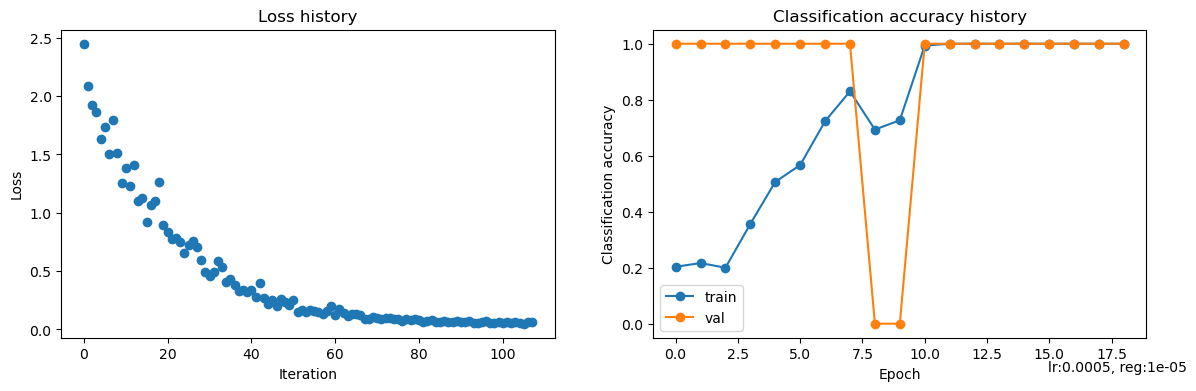

lr:0.0001  reg:1e-05
(用时 0.17s; 迭代次数1 / 108) loss: 2.608987
(Epoch 0 / 18, train 准确率: 16.33%, val准确率: 0.00%
(Epoch 1 / 18, train 准确率: 19.67%, val准确率: 100.00%
更新:当前准确率100.00, 大于之前的最佳准确率0.00

(Epoch 2 / 18, train 准确率: 20.33%, val准确率: 100.00%
(Epoch 3 / 18, train 准确率: 74.00%, val准确率: 100.00%
(Epoch 4 / 18, train 准确率: 89.67%, val准确率: 100.00%
(Epoch 5 / 18, train 准确率: 96.33%, val准确率: 100.00%
(Epoch 6 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 7 / 18, train 准确率: 100.00%, val准确率: 0.00%
(Epoch 8 / 18, train 准确率: 100.00%, val准确率: 100.00%
(用时 12.42s; 迭代次数51 / 108) loss: 0.174859
(Epoch 9 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 10 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 11 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 12 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 13 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 14 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 15 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 16 / 18, train 准确率: 100.00%, val准确率: 100.00%
(用时

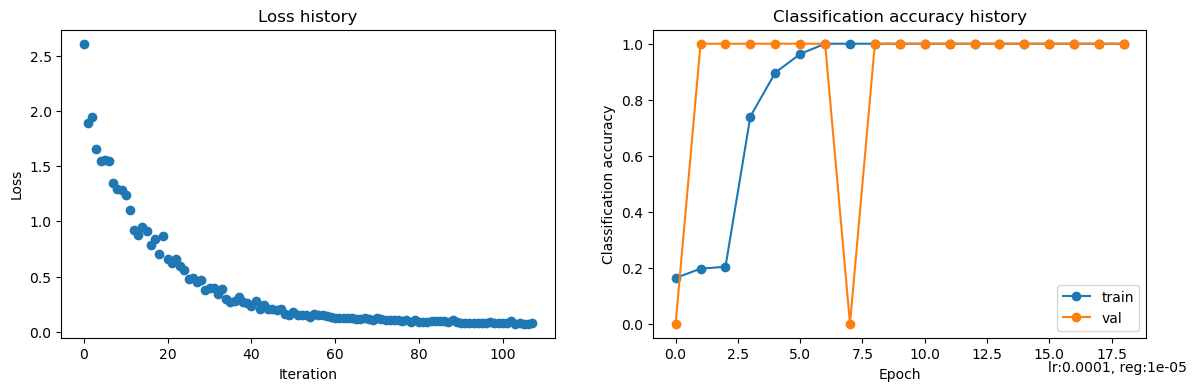

lr:5e-05  reg:1e-05
(用时 0.17s; 迭代次数1 / 108) loss: 2.405315
(Epoch 0 / 18, train 准确率: 15.67%, val准确率: 0.00%
(Epoch 1 / 18, train 准确率: 23.00%, val准确率: 0.00%
(Epoch 2 / 18, train 准确率: 31.67%, val准确率: 100.00%
更新:当前准确率100.00, 大于之前的最佳准确率0.00

(Epoch 3 / 18, train 准确率: 70.00%, val准确率: 100.00%
(Epoch 4 / 18, train 准确率: 93.00%, val准确率: 100.00%
(Epoch 5 / 18, train 准确率: 97.00%, val准确率: 100.00%
(Epoch 6 / 18, train 准确率: 98.00%, val准确率: 100.00%
(Epoch 7 / 18, train 准确率: 99.33%, val准确率: 100.00%
(Epoch 8 / 18, train 准确率: 99.67%, val准确率: 100.00%
(用时 12.41s; 迭代次数51 / 108) loss: 0.192460
(Epoch 9 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 10 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 11 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 12 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 13 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 14 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 15 / 18, train 准确率: 100.00%, val准确率: 100.00%
(Epoch 16 / 18, train 准确率: 100.00%, val准确率: 100.00%
(用时 23.

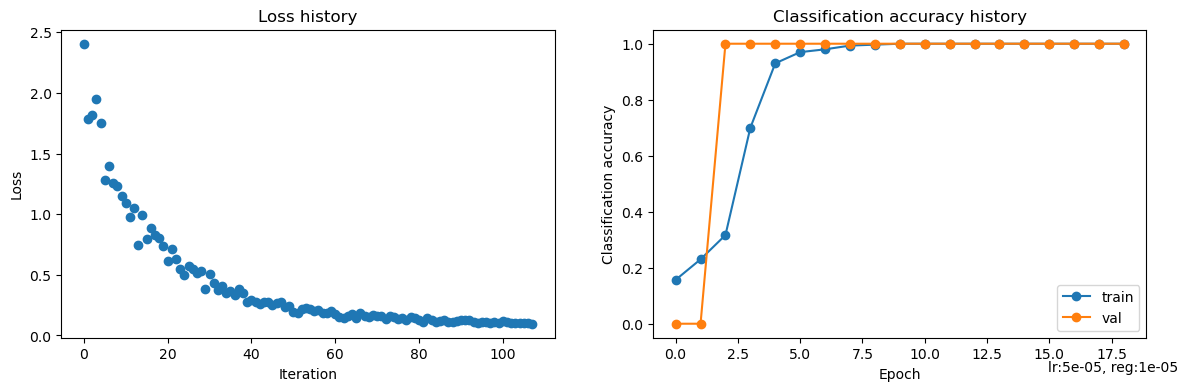

In [4]:
search_params()

# 训练与保存

In [3]:

net = VggNet(
            input_dims=(3, 32, 32),
            num_filters=(64, 128, 
                        256, 512),
            num_FC=(512,10),
            max_pools=(1,),
            weight_scale='kaiming',
            kaiming_ratio=0.4,
            reg=1e-2,
            dtype=torch.float32,
            # print_params=False,
            dropout=0.9,
            device='cuda'
        )
net.check_loss(data_dict)

solver = Solver(net, data_dict,
                num_epochs=50, batch_size=100,
                optim_config={
                'learning_rate': 5e-5,
                },
                update_rule=adam,
                verbose=True, 
                device='cuda',
                lr_decay=0.95,
                print_every=50,
                check_batch_size=20
                )


使用dropout。
tensor([[-6.9584e+08,  6.9619e+08, -6.7044e+08, -4.5350e+08, -1.2967e+08,
          1.7404e+08, -6.0363e+08, -3.6229e+07,  2.1035e+08, -1.5224e+08],
        [-8.8789e+08, -3.0946e+08, -4.8881e+07, -9.1801e+08,  7.2121e+08,
          5.5571e+08, -2.1219e+09, -8.2015e+08,  1.4233e+09, -3.2904e+08],
        [-8.5196e+08, -1.1539e+09,  8.4422e+08,  5.1007e+08,  1.1763e+09,
          1.0506e+09,  3.8331e+08, -2.1146e+08,  1.8158e+09, -2.3579e+08],
        [-1.5803e+09,  1.9822e+08,  5.3847e+08, -3.3716e+08, -2.3963e+08,
          5.8172e+08, -1.8083e+08, -5.8026e+08,  9.5582e+08,  9.7468e+08],
        [-1.6513e+09,  4.0581e+08,  5.0147e+08, -2.1500e+08, -3.4075e+08,
          1.5229e+09, -5.8699e+08,  4.8978e+08,  1.9449e+09,  3.6986e+08],
        [-8.8214e+08,  5.7029e+08,  1.1258e+09, -1.3154e+09,  1.5882e+09,
          1.5197e+09, -5.7900e+08, -9.2669e+08,  1.0788e+09,  2.0034e+08],
        [-1.5333e+09,  4.4655e+08,  8.9144e+08, -7.8315e+08,  1.0699e+08,
          1.5583e+09,

In [ ]:
clear()
solver.train(time_limit=3600)

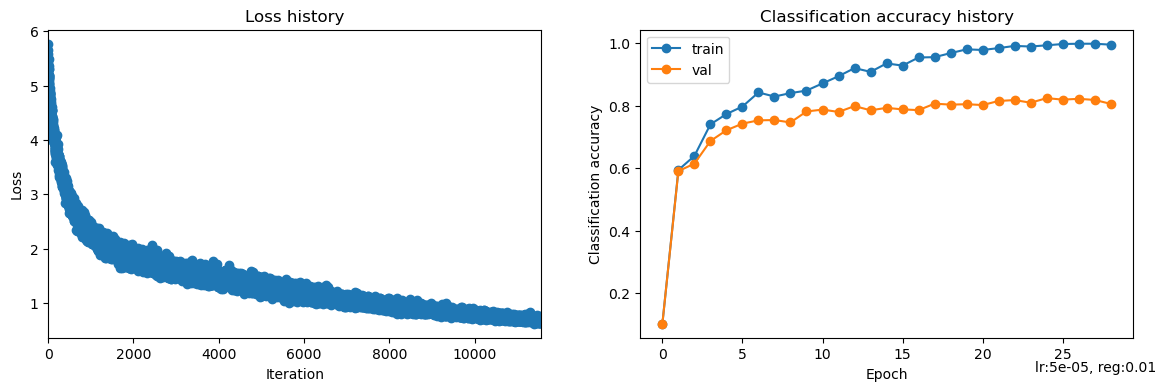

验证集准确率:82.11%


In [42]:
# 绘制训练历史曲线
plot_solver(solver)
# 重测准确率
acc = solver.check_accuracy(data_dict['X_val'],data_dict['y_val'])
print(f"验证集准确率:{acc*100:.2f}%")

In [25]:
# solver.checkpoint_name = "5_25_mini"
# solver._save_checkpoint()
from datetime import datetime
time_str = datetime.now().strftime("%m_%d_%H%M%S")
model_name = f"net_{time_str}.pth"
try:
    sv_path = "./drive/My Drive/ConvNetFromScratch/" + model_name
    net.save(sv_path)
except:
    sv_path = model_name
    net.save(sv_path)

Saved in net_05_28_215624.pth


# 加载模型与可视化推理结果

In [14]:
from convolutional_networks import VggNet
from toolset.data import *
import torch
net = VggNet()
model_path = "net_05_28_215624.pth"
device = 'cuda' if torch.cuda.is_available else 'cpu'
net.load("net_05_28_215624.pth", dtype=torch.float,device=device)
net.print_params()
data_dict = data.preprocess_cifar10(cuda=True, dtype=torch.float32, flatten=False,show_examples=False)

成功加载checkpoint文件: net_05_28_215624.pth
参数:
	W1: torch.Size([64, 3, 3, 3])
	b1: torch.Size([64])
	gamma1: torch.Size([64])
	beta1: torch.Size([64])
	W2: torch.Size([128, 64, 3, 3])
	b2: torch.Size([128])
	gamma2: torch.Size([128])
	beta2: torch.Size([128])
	W3: torch.Size([256, 128, 3, 3])
	b3: torch.Size([256])
	gamma3: torch.Size([256])
	beta3: torch.Size([256])
	W4: torch.Size([512, 256, 3, 3])
	b4: torch.Size([512])
	gamma4: torch.Size([512])
	beta4: torch.Size([512])
	W5: torch.Size([131072, 512])
	b5: torch.Size([512])
	gamma5: torch.Size([512])
	beta5: torch.Size([512])
	W6: torch.Size([512, 10])
	b6: torch.Size([10])


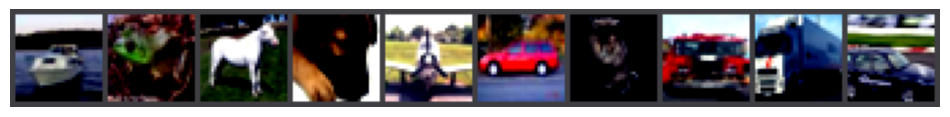

ship,frog,horse,dog,plane,car,cat,truck,truck,car


In [13]:
# “看到”推理结果
start_it = 500
end_it = start_it + 10
X_samples = data_dict['X_val'][start_it:end_it]
y_samples = data_dict['y_val'][start_it:end_it]
X_samples.to('cuda')
y_samples.to('cuda')
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

forecast = []
for i in net.loss(X_samples).argmax(dim=1):
    forecast.append(classes[i])
tensor_to_imggrid_show(X_samples)
print(",".join(forecast))

# VGG16示例

In [ ]:
# Vgg16的结构来自原论文 
net16 = VggNet(
                input_dims=(3, 32, 32),
                num_filters=(64, 64, 
                            128, 128, 
                            256, 256, 256, 
                            512, 512, 512, 
                            512, 512, 512),
                num_FC=(4096, 4096, 10),
                max_pools=(1, 3, 6, 9, 12),
                weight_scale='kaiming',
                kaiming_ratio=0.1,
                reg=5e-4,
                dtype=torch.float32,
                print_params=True,
                dropout=0.5,
                device='cuda'
)
